# 对《红楼梦》书籍的挖掘

## 文本预处理

In [1]:
## 加载数据包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
import nltk

In [2]:
## 设置显示偏好
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",None)

## 读取文章、停用词和需要的词典
stop_words = pd.read_csv(r"C:\Users\mzjj\Desktop\基于Python的红楼梦文本分析\input\stop_words.txt",header=None,names = ["stop_words"])
dictionary = pd.read_csv(r"C:\Users\mzjj\Desktop\基于Python的红楼梦文本分析\input\Red_Mansion_Dictionary.txt",header=None, names=["dictionary"])
content = pd.read_csv(r"C:\Users\mzjj\Desktop\基于Python的红楼梦文本分析\input\Dream_of_the_Red_Mansion.txt",header=None,names = ["content"])

print(content.head(),'\n\n',dictionary.head(),'\n\n',stop_words.head())

                                             content
0                                                第1卷
1                              第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
2  　　此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<...
3                 　　此回中凡用“梦”用“幻”等字，是提醒阅者眼目，亦是此书立意本旨。
4  　　列位看官：你道此书从何而来？说起根由虽近荒唐，细按则深有趣味。待在下将此来历注明，方使阅... 

   dictionary
0         黛玉
1         宝钗
2         贾演
3         贾寅
4         贾源 

   stop_words
0          $
1          0
2          1
3          2
4          3


In [4]:
## 使用正则表达式，选取相应索引
index_of_juan = content.content.str.contains("^第+.+卷") 

## 根据索引删除不需要的行，并重新设置索引
content = content[~index_of_juan].reset_index(drop=True) 
content.head()

,content
0,第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
1,此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<...
2,此回中凡用“梦”用“幻”等字，是提醒阅者眼目，亦是此书立意本旨。
3,列位看官：你道此书从何而来？说起根由虽近荒唐，细按则深有趣味。待在下将此来历注明，方使阅...
4,原来女娲氏炼石补天之时，于大荒山无稽崖练成高经十二丈，方经二十四丈顽石三万六千五百零一块...


In [5]:
## 使用正则表达式，选取相应索引
index_of_hui = content.content.str.match("^第+.+回")

## 根据索引选取每一章节的标题
chapter_names = content.content[index_of_hui].reset_index(drop=True)
chapter_names.head()

0    第一回 甄士隐梦幻识通灵 贾雨村风尘怀闺秀
1    第二回 贾夫人仙逝扬州城 冷子兴演说荣国府
2    第三回 贾雨村夤缘复旧职 林黛玉抛父进京都
3    第四回 薄命女偏逢薄命郎 葫芦僧乱判葫芦案
4    第五回 游幻境指迷十二钗 饮仙醪曲演红楼梦
Name: content, dtype: object

In [6]:
## 处理章节名，按照空格分割字符串
chapter_names_split = chapter_names.str.split(" ").reset_index(drop=True)
chapter_names_split.head()

0    [第一回, 甄士隐梦幻识通灵, 贾雨村风尘怀闺秀]
1    [第二回, 贾夫人仙逝扬州城, 冷子兴演说荣国府]
2    [第三回, 贾雨村夤缘复旧职, 林黛玉抛父进京都]
3    [第四回, 薄命女偏逢薄命郎, 葫芦僧乱判葫芦案]
4    [第五回, 游幻境指迷十二钗, 饮仙醪曲演红楼梦]
Name: content, dtype: object

In [8]:
## 建立保存数据的数据框
data = pd.DataFrame(list(chapter_names_split),columns=["chapter","left_name","right_name"])

## 添加章节序号和章节名称列
data["chapter_number"] = np.arange(1,121)
data["chapter_name"] = data.left_name+","+data.right_name

## 添加每章开始的行位置
data["start_id"] = index_of_hui[index_of_hui == True].index

## 添加每章结束的行位置
data["end_id"] = data["start_id"][1:len(data["start_id"])].reset_index(drop = True) - 1
data["end_id"][[len(data["end_id"])-1]] = content.index[-1]

## 添加每章的行数
data["length_of_chapters"] = data.end_id - data.start_id

data.head()

,chapter,left_name,right_name,chapter_number,chapter_name,start_id,end_id,length_of_chapters
0,第一回,甄士隐梦幻识通灵,贾雨村风尘怀闺秀,1,"甄士隐梦幻识通灵,贾雨村风尘怀闺秀",0,49.0,49.0
1,第二回,贾夫人仙逝扬州城,冷子兴演说荣国府,2,"贾夫人仙逝扬州城,冷子兴演说荣国府",50,79.0,29.0
2,第三回,贾雨村夤缘复旧职,林黛玉抛父进京都,3,"贾雨村夤缘复旧职,林黛玉抛父进京都",80,118.0,38.0
3,第四回,薄命女偏逢薄命郎,葫芦僧乱判葫芦案,4,"薄命女偏逢薄命郎,葫芦僧乱判葫芦案",119,148.0,29.0
4,第五回,游幻境指迷十二钗,饮仙醪曲演红楼梦,5,"游幻境指迷十二钗,饮仙醪曲演红楼梦",149,235.0,86.0


In [11]:
## 添加每章节的内容
data["content"] = ''

for i in data.index:
    ## 将内容使用""连接
    chapter_id = np.arange(data.start_id[i]+1,int(data.end_id[i]))
    ## 每章节的内容替换掉空格
    data["content"][i] = "".join(list(content.content[chapter_id])).replace("　　","")
    
## 添加每章字数
data["length_of_characters"] = data.content.apply(len)
data.drop(columns=['left_name','right_name','start_id','end_id'])

,chapter,chapter_number,chapter_name,length_of_chapters,content,length_of_characters
0,第一回,1,"甄士隐梦幻识通灵,贾雨村风尘怀闺秀",49.0,此开卷第一回也。作者自云：因曾历过一番梦幻之后，故将真事隐去，而借“通灵”之说，撰此<<石头...,7594
1,第二回,2,"贾夫人仙逝扬州城,冷子兴演说荣国府",29.0,诗云一局输赢料不真，香销茶尽尚逡巡。欲知目下兴衰兆，须问旁观冷眼人。却说封肃因听见公差传唤，...,5659
2,第三回,3,"贾雨村夤缘复旧职,林黛玉抛父进京都",38.0,却说雨村忙回头看时，不是别人，乃是当日同僚一案参革的号张如圭者。他本系此地人，革后家居，今打...,8332
3,第四回,4,"薄命女偏逢薄命郎,葫芦僧乱判葫芦案",29.0,却说黛玉同姊妹们至王夫人处，见王夫人与兄嫂处的来使计议家务，又说姨母家遭人命官司等语。因见王...,5841
4,第五回,5,"游幻境指迷十二钗,饮仙醪曲演红楼梦",86.0,第四回中既将薛家母子在荣府内寄居等事略已表明，此回则暂不能写矣。如今且说林黛玉自在荣府以来，...,7401
5,第六回,6,"贾宝玉初试云雨情,刘姥姥一进荣国府",26.0,却说秦氏因听见宝玉从梦中唤他的乳名，心中自是纳闷，又不好细问。彼时宝玉迷迷惑惑，若有所失。众...,7258
6,第七回,7,"送宫花贾琏戏熙凤,宴宁府宝玉会秦钟",26.0,话说周瑞家的送了刘姥姥去后，便上来回王夫人话。谁知王夫人不在上房，问丫鬟们时，方知往薛姨妈那...,7301
7,第八回,8,"比通灵金莺微露意,探宝钗黛玉半含酸",36.0,话说凤姐和宝玉回家，见过众人。宝玉先便回明贾母秦钟要上家塾之事，自己也有了个伴读的朋友，正好...,6483
8,第九回,9,"恋风流情友入家塾,起嫌疑顽童闹学堂",16.0,话说秦业父子专候贾家的人来送上学择日之信。原来宝玉急于要和秦钟相遇，却顾不得别的，遂择了后日...,5365
9,第十回,10,"金寡妇贪利权受辱,张太医论病细穷源",22.0,话说金荣因人多势众，又兼贾瑞勒令，赔了不是，给秦钟磕了头，宝玉方才不吵闹了。大家散了学，金荣...,4676


In [13]:
## 对红楼梦全文进行分词

## 数据表的行列数
row,col = data.shape

## 预定义列表
data["cutted_words"] = ''

# 指定自定义的词典，以便包含jieba词库里没有的词，保证更高的正确率
jieba.load_userdict(r'C:\Users\mzjj\Desktop\基于Python的红楼梦文本分析\input\Red_Mansion_Dictionary.txt')

for i in np.arange(row):
    ## 分词
    cutwords = list(jieba.cut(data.content[i]))
    ## 去除长度为1的词
    cutwords = pd.Series(cutwords)[pd.Series(cutwords).apply(len)>1]
    ## 去停用词
    cutwords = cutwords[~cutwords.isin(stop_words)]
    data.cutted_words[i] = cutwords.values

# 添加每一章节的词数
data['length_of_words'] = data.cutted_words.apply(len)
data['cutted_words'].head()

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\mzjj\AppData\Local\Temp\jieba.cache
Loading model cost 0.844 seconds.
Prefix dict has been built succesfully.


0    [开卷, 第一回, 作者, 自云, 因曾, 历过, 一番, 梦幻, 之后, 真事, 隐去, ...
1    [诗云, 一局, 输赢, 料不真, 香销, 尽尚, 逡巡, 欲知, 目下, 兴衰, 旁观, ...
2    [却说, 雨村, 回头, 看时, 不是, 别人, 乃是, 当日, 同僚, 一案, 参革, 张...
3    [却说, 黛玉, 姊妹, 王夫人, 王夫人, 兄嫂, 计议, 家务, 姨母, 家遭, 人命官...
4    [第四回, 薛家, 母子, 荣府内, 寄居, 事略, 表明, 此回, 不能, 如今, 且说,...
Name: cutted_words, dtype: object

In [25]:
data['cutted_words']

0      [开卷, 第一回, 作者, 自云, 因曾, 历过, 一番, 梦幻, 之后, 真事, 隐去, ...
1      [诗云, 一局, 输赢, 料不真, 香销, 尽尚, 逡巡, 欲知, 目下, 兴衰, 旁观, ...
2      [却说, 雨村, 回头, 看时, 不是, 别人, 乃是, 当日, 同僚, 一案, 参革, 张...
3      [却说, 黛玉, 姊妹, 王夫人, 王夫人, 兄嫂, 计议, 家务, 姨母, 家遭, 人命官...
4      [第四回, 薛家, 母子, 荣府内, 寄居, 事略, 表明, 此回, 不能, 如今, 且说,...
5      [却说, 秦氏, 听见, 宝玉, 中唤, 乳名, 心中, 纳闷, 不好, 细问, 彼时, 宝...
6      [周瑞家的, 刘姥姥, 来回, 王夫人, 谁知, 王夫人, 上房, 丫鬟, 方知, 薛姨妈,...
7      [凤姐, 宝玉, 回家, 见过, 众人, 宝玉, 先便, 明贾母, 秦钟, 家塾, 自己, ...
8      [秦业, 父子, 专候, 贾家, 人来, 上学, 择日, 之信, 原来, 宝玉, 急于, 秦...
9      [金荣, 人多势众, 贾瑞, 勒令, 不是, 秦钟, 宝玉, 方才, 吵闹, 大家, 金荣,...
10     [贾敬, 寿辰, 贾珍先, 东西, 稀奇, 果品, 十六大, 贾蓉, 带领, 家下, 贾敬,...
11     [凤姐, 平儿, 说话, 只见, 有人, 回说, 大爷, 凤姐, 急命, 请进来, 贾瑞见,...
12     [凤姐儿, 贾琏, 黛玉, 扬州, 心中, 实在, 无趣, 每到, 晚间, 不过, 平儿, ...
13     [宁国府, 总管, 来升闻, 里面, 委请, 凤姐, 因传齐, 同事, 说道, 如今, 西府...
14     [宝玉, 举目, 北静王, 水溶, 头上, 戴着, 洁白, 簪缨, 银翅, 王帽, 穿着, ...
15     [宝玉, 收拾, 书房, 约定, 秦钟, 读夜, 那秦钟, 秉赋, 因在, 郊外, 风霜, ...
16     [秦钟, 宝玉, 痛哭, 不已, 李贵, 好容易, 劝解, 半日方, 归时, 凄恻, 哀痛,...
17     [宝玉, 至院, 贾政, 几个, 小厮, 上来,

## 基础描述性分析

### 人物提及次数条形图

In [15]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec  2 15:25:47 2021

@author: 木子津九
"""

#可视化库
import pandas as pd
from pyecharts.charts import *
from pyecharts import options as opts
from pyecharts.globals import ThemeType
from pyecharts.render import make_snapshot

tmp=[]
corpus=[]
for i in data['cutted_words']:
    for j in i:
        corpus.append(j)

for i in corpus:
    if "宝玉" in i:
        tmp.append("宝玉")
    if "贾宝玉" in i:
        tmp.append("宝玉")
    elif "晴雯" in i:
        tmp.append("晴雯")
    elif "史湘云" in i:
        tmp.append("史湘云")
    elif "妙玉" in i:
        tmp.append("妙玉")
    elif "秦可卿" in i:
        tmp.append("秦可卿")
    elif "袭人" in i:
        tmp.append("袭人")
    elif "宝钗" in i:
        tmp.append("宝钗")
    elif "黛玉" in i:
        tmp.append("黛玉")
    elif "宝二爷" in i:
        tmp.append("宝玉")
    elif "二爷" in i:
        tmp.append("宝玉")
    elif "老太太" in i:
        tmp.append("贾母")
    elif "二奶奶" in i:
        tmp.append("王熙凤")
    elif "王熙凤" in i:
        tmp.append("王熙凤")
    elif "凤姐" in i:
        tmp.append("王熙凤")
    elif "贾母" in i:
        tmp.append("贾母")
    elif "探春" in i:
        tmp.append("探春")
    elif "迎春" in i:
        tmp.append("迎春")
    elif "探春" in i:
        tmp.append("探春")        
    elif "惜春" in i:
        tmp.append("惜春")        
    elif "元春" in i:
        tmp.append("元春")
    elif "王夫人" in i:
        tmp.append("王夫人")
    else:
        tmp.append("其他")
df=pd.DataFrame()
df['人物提及'] = tmp
df8 = df["人物提及"].value_counts()[1:10]
print(df8.index.to_list())
print(df8.to_list())
c = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.DARK))
    .add_xaxis(df8.index.to_list())
    .add_yaxis("",df8.to_list())
    .set_global_opts(title_opts=opts.TitleOpts(title="人物提及次数",subtitle="数据分析：红楼梦",pos_left = 'center'),
                       xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=13)), #更改横坐标字体大小
                       yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(font_size=13)), #更改纵坐标字体大小
                       )
    .set_series_opts(label_opts=opts.LabelOpts(font_size=16,position='top'))
    )
c.render_notebook()

['宝玉', '贾母', '王熙凤', '黛玉', '袭人', '宝钗', '王夫人', '探春', '晴雯']
[4358, 2580, 1678, 1305, 1103, 1022, 976, 424, 340]


### 词云图的绘制

In [210]:
from operator import itemgetter
freq_dict=nltk.FreqDist(corpus)
top_freq_dict=sorted(freq_dict.items(),key=itemgetter(1),reverse=True)#key:sorted by value
list=[]
for i in top_freq_dict:
    if len(i[0])>=2:
        list.append(i)
print(list)

[('宝玉', 3662), ('什么', 1580), ('一个', 1411), ('贾母', 1237), ('我们', 1189), ('凤姐', 1160), ('那里', 1143), ('袭人', 1103), ('黛玉', 1002), ('如今', 982), ('你们', 977), ('王夫人', 976), ('说道', 956), ('老太太', 948), ('知道', 947), ('姑娘', 921), ('起来', 919), ('这里', 917), ('出来', 904), ('他们', 881), ('众人', 834), ('奶奶', 832), ('自己', 816), ('一面', 808), ('太太', 806), ('宝钗', 770), ('只见', 758), ('没有', 754), ('两个', 752), ('怎么', 746), ('不是', 712), ('这个', 680), ('贾琏', 666), ('听见', 665), ('不知', 656), ('这样', 647), ('进来', 616), ('咱们', 592), ('东西', 590), ('就是', 586), ('告诉', 581), ('平儿', 564), ('回来', 548), ('只是', 529), ('大家', 523), ('老爷', 516), ('只得', 512), ('这些', 496), ('丫头', 489), ('不敢', 482), ('出去', 467), ('凤姐儿', 464), ('所以', 459), ('贾政', 452), ('薛姨妈', 438), ('的话', 437), ('不过', 435), ('姐姐', 430), ('不好', 427), ('探春', 421), ('紫鹃', 416), ('不能', 409), ('一时', 406), ('鸳鸯', 406), ('过来', 405), ('心里', 393), ('二爷', 387), ('今日', 364), ('如此', 364), ('银子', 360), ('李纨', 359), ('几个', 352), ('二人', 349), ('还有', 344), ('答应', 344), ('晴雯', 335)

In [211]:
from pyecharts.charts import WordCloud
w = (
    WordCloud()
    .add("",list[:100],shape='star',word_size_range=[12, 55])
    .set_global_opts(title_opts=opts.TitleOpts(title="红楼梦词云图"))
)
w.render_notebook()

## 章节间分析

### 前80回与后40回分析

<Figure size 864x720 with 0 Axes>

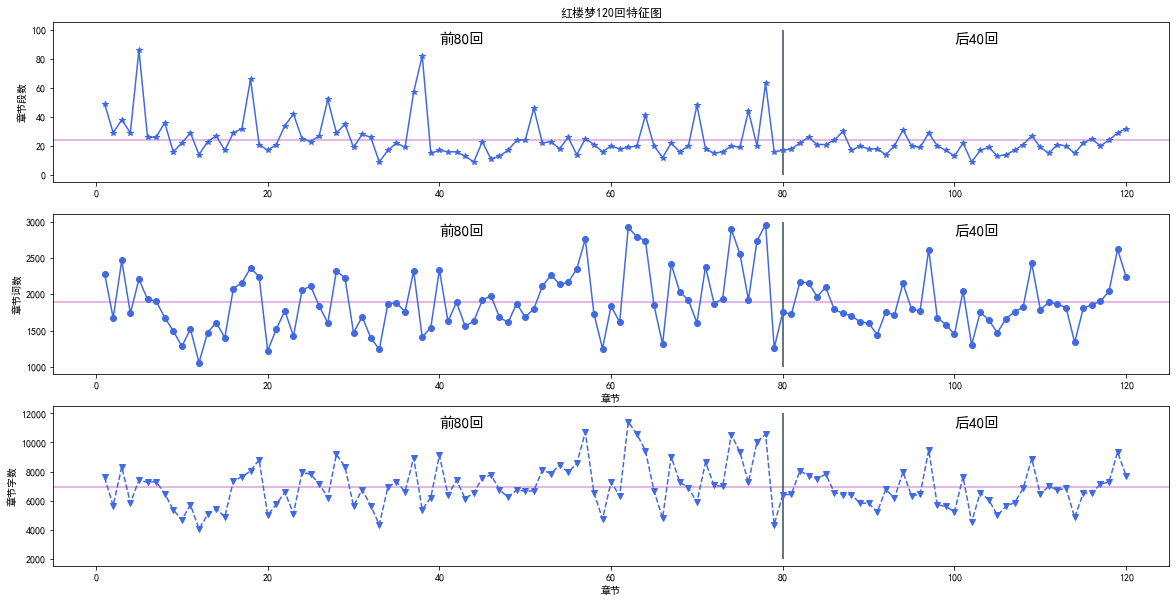

In [14]:
plt.figure(figsize=(12,10))
plt.rcParams['font.family'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,10))
plt.subplot(3,1,1)
plt.plot(data.chapter_number,data.length_of_chapters,linestyle='-',marker='*',color="royalblue")

plt.ylabel("章节段数")
plt.title("红楼梦120回特征图")
plt.hlines(np.mean(data.length_of_chapters),-5,125,"plum")
plt.vlines(80,0,100,"darkslategray")
plt.text(40,90,'前80回',fontsize = 15)
plt.text(100,90,'后40回',fontsize = 15)
plt.xlim((-5,125))

plt.subplot(3,1,2)
plt.plot(data.chapter_number,data.length_of_words,marker="o", linestyle="-",color="royalblue")
plt.xlabel("章节")
plt.ylabel("章节词数")
plt.hlines(np.mean(data.length_of_words),-5,125,"plum")
plt.vlines(80,1000,3000,"darkslategray")
plt.text(40,2800,'前80回',fontsize = 15)
plt.text(100,2800,'后40回',fontsize = 15)
plt.xlim((-5,125))

plt.subplot(3,1,3)
plt.plot(data.chapter_number,data.length_of_characters,linestyle='--',marker='v',color="royalblue")
plt.xlabel("章节")
plt.ylabel("章节字数")
plt.hlines(np.mean(data.length_of_characters),-5,125,"plum")
plt.vlines(80,2000,12000,"darkslategray")
plt.text(40,11000,'前80回',fontsize = 15)
plt.text(100,11000,'后40回',fontsize = 15)
plt.xlim((-5,125))
plt.savefig('红楼梦120回特征分析.png')
plt.show()

### 章节层次聚类

In [212]:
from sklearn.feature_extraction.text import TfidfVectorizer

content = []
for cutword in data.cutted_words:
    content.append(" ".join(cutword))

## 构建语料库，并计算文档的TF－IDF矩阵
transformer = TfidfVectorizer()
tfidf = transformer.fit_transform(content)

## TF－IDF以稀疏矩阵的形式存储，将TF－IDF转化为数组的形式,文档－词矩阵
word_vectors = tfidf.toarray()
word_vectors

array([[0.        , 0.        , 0.00732405, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00896651, ..., 0.        , 0.        ,
        0.        ],
       [0.04321759, 0.        , 0.04867475, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00731153, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00886058, ..., 0.        , 0.        ,
        0.        ]])

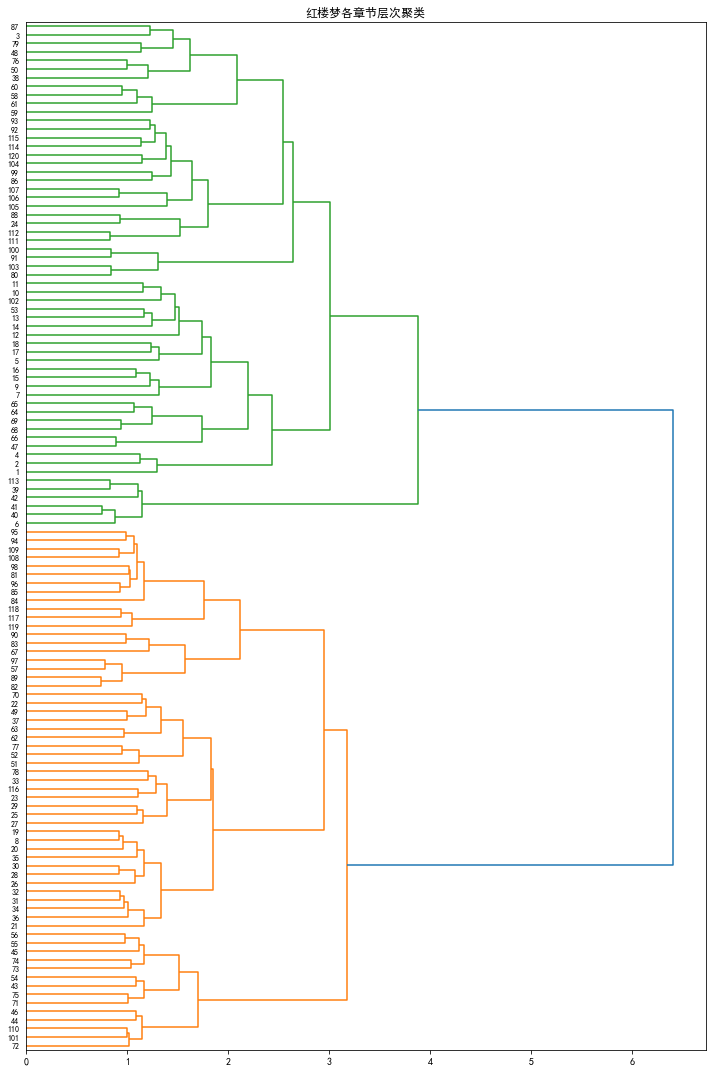

In [213]:
from scipy.cluster.hierarchy import dendrogram,ward
from scipy.spatial.distance import pdist,squareform

## 标签，每个章节的标题
labels = data.chapter_number.values

#计算每章的距离矩阵
cos_distance_matrix = squareform(pdist(word_vectors,'cosine'))

## 根据距离聚类
ward_results = ward(cos_distance_matrix)  

## 聚类结果可视化
fig, ax = plt.subplots(figsize=(10, 15))

ax = dendrogram(ward_results,orientation='right', labels=labels);
plt.yticks(size = 8)
plt.title("红楼梦各章节层次聚类")

plt.tight_layout()
plt.show()   

## 人物间的挖掘分析

In [67]:
import matplotlib.pyplot as plt
with open(r'C:\Users\mzjj\Desktop\基于Python的红楼梦文本分析\input\Red_Mansion_Dictionary.txt',encoding="utf-8") as f:
    characters_names = [line.strip('\n') for line in f.readlines()]

with open(r"C:\Users\mzjj\Desktop\基于Python的红楼梦文本分析\input\Dream_of_the_Red_Mansion.txt",encoding="utf-8") as f:
    content = f.read()
count = []

for name in characters_names:
    count.append([name, content.count(name)])
count.sort(key=lambda x: x[1])

In [19]:
import gensim
import jieba
import re
from operator import itemgetter
from zhon.hanzi import punctuation
with open(r"C:\Users\mzjj\Desktop\基于Python的红楼梦文本分析\input\Dream_of_the_Red_Mansion.txt",encoding="utf-8") as f:
    content = [line.strip() for line in f.readlines() if line.strip()]
    
sentences = []
for name in characters_names:
    jieba.add_word(name)
def remove_characters_before_tokenization(sentence):
    sentence=sentence.strip()
    pattern=re.compile('[?|$|&|*|%|@|(|)!~]')
    filtered_sentence=re.sub(pattern,'',sentence)
    filtered_sentence = re.sub(u"([^\u4e00-\u9fa5\u0030-\u0039\u0041-\u005a\u0061-\u007a])","",sentence)
    filtered_sentence = re.sub('[a-zA-Z]','',filtered_sentence)
    for i in punctuation:
        filtered_sentence=filtered_sentence.replace(i,'')
    return filtered_sentence
filtered_corpus=[]
for i in content:
    filtered_corpus.append(remove_characters_before_tokenization(i))
    
for line in filtered_corpus:
    words = jieba.lcut(line)
    sentences.append(words)

stop_words = []
with open(r'C:\所有文件\大三上课程\文本挖掘\chapter2\chapter2\htu_stopword.txt', 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for line in lines:
            stop_words.append(line.strip())
cleanwords=[i for i in sentences if i not in stop_words]
sentences

[['第', '1', '卷'],
 ['第一回', '甄士隐', '梦幻', '识通灵', '贾雨村', '风尘', '怀', '闺秀'],
 ['此',
  '开卷',
  '第一回',
  '也',
  '作者',
  '自云因',
  '曾',
  '历过',
  '一番',
  '梦幻',
  '之后',
  '故',
  '将',
  '真事',
  '隐去',
  '而',
  '借',
  '通灵之',
  '说',
  '撰此',
  '石头记',
  '一书',
  '也',
  '故曰',
  '甄士隐',
  '云云',
  '但书中',
  '所记',
  '何事',
  '何人',
  '自',
  '又',
  '云今',
  '风尘碌碌',
  '一事无成',
  '忽',
  '念及',
  '当日',
  '所有',
  '之',
  '女子',
  '一一',
  '细考',
  '较',
  '去',
  '觉',
  '其',
  '行止',
  '见识',
  '皆',
  '出于',
  '我',
  '之上',
  '何',
  '我',
  '堂堂',
  '须眉',
  '诚不若',
  '彼',
  '裙钗',
  '哉',
  '实愧',
  '则',
  '有余',
  '悔',
  '又',
  '无益',
  '之大',
  '无可如何',
  '之日',
  '也',
  '当此',
  '则',
  '自欲',
  '将',
  '已往',
  '所赖',
  '天恩祖',
  '德',
  '锦衣',
  '纨',
  '之',
  '时',
  '饫甘餍肥',
  '之日',
  '背',
  '父兄',
  '教育',
  '之恩负',
  '师友',
  '规谈',
  '之德',
  '以至',
  '今日',
  '一技无成',
  '半生',
  '潦倒',
  '之罪',
  '编述',
  '一集',
  '以告',
  '天下人',
  '我',
  '之',
  '罪固',
  '不免',
  '然',
  '闺阁',
  '中本',
  '自',
  '历历',
  '有人',
  '万',
  '不可',
  '因',
  '我',
  '之',
  '不肖',
  '自护己

### 基于Word2Vec 构建词向量模型

In [20]:
model = gensim.models.Word2Vec(sentences,window=20,min_count=5,workers=4)

In [66]:
for k, s in model.wv.most_similar(positive=["老太太"]):
    print('{}:{}'.format(k, s))

太太:0.9753561019897461
老爷:0.9581583142280579
二爷:0.9532387852668762
奶奶:0.9272785782814026
姨太太:0.9212097525596619
姑娘:0.9171176552772522
二:0.9071904420852661
我们:0.9021970629692078
林姑娘:0.8925784826278687
妹妹:0.8786607384681702


In [83]:
for k, s in model.wv.most_similar(positive=["宝玉"]):
    print('{}:{}'.format(k, s))

黛玉:0.9142220616340637
宝钗:0.9090636372566223
晴雯:0.9088836908340454
林黛玉:0.9069648385047913
方想:0.9026729464530945
起来:0.8953823447227478
乜斜:0.8837873935699463
听:0.8785687685012817
紫鹃:0.8781765699386597
胡诌:0.875339686870575


In [87]:
def find_relationship(tranning_model, a, b, c):
    """
    返回 d
    a与b的关系，跟c与d的关系一样
    """
    d, _ = tranning_model.wv.most_similar(positive=[c, b], negative=[a])[0]
    print("给定“{}”与“{}”，“{}”和“{}”有类似的关系".format(a, b, c, d))
    
find_relationship(model, '宝玉', '袭人', '黛玉')

给定“宝玉”与“袭人”，“黛玉”和“紫鹃”有类似的关系


### 人物身份聚类

In [21]:
def kmeans(model, characters_names):
    all_names = []

    word_vectors = None
    np_names = None
    for name in characters_names:
        if name in model.wv.index_to_key:
            all_names.append(name)
    for name in all_names:
        if word_vectors is None:
            word_vectors = model.wv[name]
        else:
            word_vectors = np.vstack((word_vectors, model.wv[name]))
            np_names = np.array(all_names)

    return np_names, word_vectors

np_names, word_vectors = kmeans(model, characters_names)

print(np_names,'\n',word_vectors)

['黛玉' '宝钗' '贾敬' '贾赦' '贾政' '贾珍' '贾琏' '贾珠' '贾母' '贾宝玉' '宝玉' '贾环' '贾瑞' '贾蓉'
 '贾兰' '贾蔷' '贾菌' '贾芸' '贾芹' '贾菖' '贾菱' '巧姐儿' '史湘云' '王子腾' '王夫人' '王仁' '王熙凤'
 '凤姐' '薛姨妈' '薛蟠' '薛蝌' '薛宝钗' '薛宝琴' '林黛玉' '林妹妹' '邢夫人' '尤氏' '李纨' '贾蓉之妻' '香菱'
 '妙玉' '赵姨娘' '刘姥姥' '甄宝玉' '袭人' '晴雯' '绮霰' '麝月' '檀云' '秋纹' '茜雪' '春燕' '坠儿' '四儿'
 '佳蕙' '司棋' '待书' '入画' '彩屏' '翠墨' '莲花儿' '紫鹃' '雪雁' '鸳鸯' '琥珀' '珍珠' '玻璃' '翡翠'
 '莺儿' '平儿' '小红' '丰儿' '金钏' '玉钏' '彩云' '彩霞' '素云' '翠缕' '宝珠' '小螺' '傻大姐' '宝蟾'
 '茗烟' '焙茗' '焦大' '李贵' '锄药' '墨雨' '来旺' '兴儿' '隆儿' '昭儿' '喜儿' '王信' '芳官' '龄官'
 '蕊官' '藕官' '宝官' '文官' '葵官' '空空道人' '甄士隐' '小童' '神瑛侍者' '警幻仙子' '贾雨村' '封肃' '冷子兴'
 '林如海' '李嬷嬷' '门子' '冯渊' '拐子' '刘氏' '板儿' '青儿' '周瑞' '周瑞家的' '智能' '秦钟' '詹光'
 '吴新登' '秦业' '金氏' '戴权' '张材家的' '冯紫英' '水溶' '净虚' '赖大' '赵嬷嬷' '林之孝' '程日兴' '花自芳'
 '多浑虫' '卜世仁' '倪二' '林之孝家的' '马道婆' '周姨娘' '蒋玉菡' '云儿' '张道士' '傅试' '宋嬷嬷' '鲍二家的'
 '金文翔' '柳湘莲' '赖尚荣' '邢岫烟' '李婶娘' '李纹' '李绮' '胡君荣' '乌进孝' '女先儿' '夏婆子' '柳家的'
 '佩凤' '尤二姐' '尤三姐' '尤老娘' '张华' '俞禄' '秋桐' '喜鸾' '王善保家的' '邢德全' '孙绍祖' '王一贴'] 
 [[ 0.7278101   0.16842732 -1.6543069  ... -2.191702   -0.3

In [30]:
from sklearn.cluster import KMeans
N = 6

label = KMeans(N).fit(word_vectors).labels_

for c in range(N):
    print("类别{}：".format(c + 1))
    for idx, name in enumerate(np_names[label == c]):
        print(name, end=", ")
        if idx % 10 == 9:
            print('')
    print('')

类别1：
贾珠, 贾菌, 贾芹, 贾菖, 贾菱, 巧姐儿, 王子腾, 王熙凤, 薛宝琴, 林妹妹, 
贾蓉之妻, 绮霰, 檀云, 茜雪, 坠儿, 四儿, 佳蕙, 待书, 入画, 翠墨, 
莲花儿, 珍珠, 翡翠, 小红, 金钏, 玉钏, 彩霞, 素云, 翠缕, 宝珠, 
小螺, 傻大姐, 焦大, 李贵, 锄药, 墨雨, 来旺, 隆儿, 昭儿, 喜儿, 
王信, 龄官, 蕊官, 宝官, 文官, 葵官, 空空道人, 甄士隐, 小童, 神瑛侍者, 
警幻仙子, 贾雨村, 封肃, 冷子兴, 林如海, 李嬷嬷, 门子, 冯渊, 拐子, 刘氏, 
板儿, 青儿, 周瑞, 詹光, 吴新登, 秦业, 金氏, 戴权, 张材家的, 净虚, 
赵嬷嬷, 程日兴, 花自芳, 多浑虫, 卜世仁, 倪二, 马道婆, 周姨娘, 蒋玉菡, 云儿, 
张道士, 傅试, 宋嬷嬷, 鲍二家的, 金文翔, 柳湘莲, 赖尚荣, 邢岫烟, 李婶娘, 李纹, 
李绮, 胡君荣, 乌进孝, 女先儿, 夏婆子, 柳家的, 佩凤, 尤老娘, 俞禄, 秋桐, 
喜鸾, 王善保家的, 邢德全, 孙绍祖, 王一贴, 
类别2：
贾敬, 贾宝玉, 贾环, 贾瑞, 贾蓉, 贾兰, 贾蔷, 贾芸, 史湘云, 王仁, 
薛蟠, 薛蝌, 薛宝钗, 香菱, 妙玉, 赵姨娘, 甄宝玉, 春燕, 司棋, 彩屏, 
琥珀, 玻璃, 丰儿, 彩云, 宝蟾, 茗烟, 焙茗, 兴儿, 藕官, 智能, 
秦钟, 冯紫英, 水溶, 赖大, 林之孝, 林之孝家的, 尤二姐, 尤三姐, 张华, 
类别3：
薛姨妈, 林黛玉, 李纨, 刘姥姥, 晴雯, 麝月, 秋纹, 雪雁, 鸳鸯, 莺儿, 
平儿, 芳官, 周瑞家的, 
类别4：
贾赦, 贾政, 贾珍, 
类别5：
贾琏, 贾母, 王夫人, 凤姐, 邢夫人, 尤氏, 
类别6：
黛玉, 宝钗, 宝玉, 袭人, 紫鹃, 


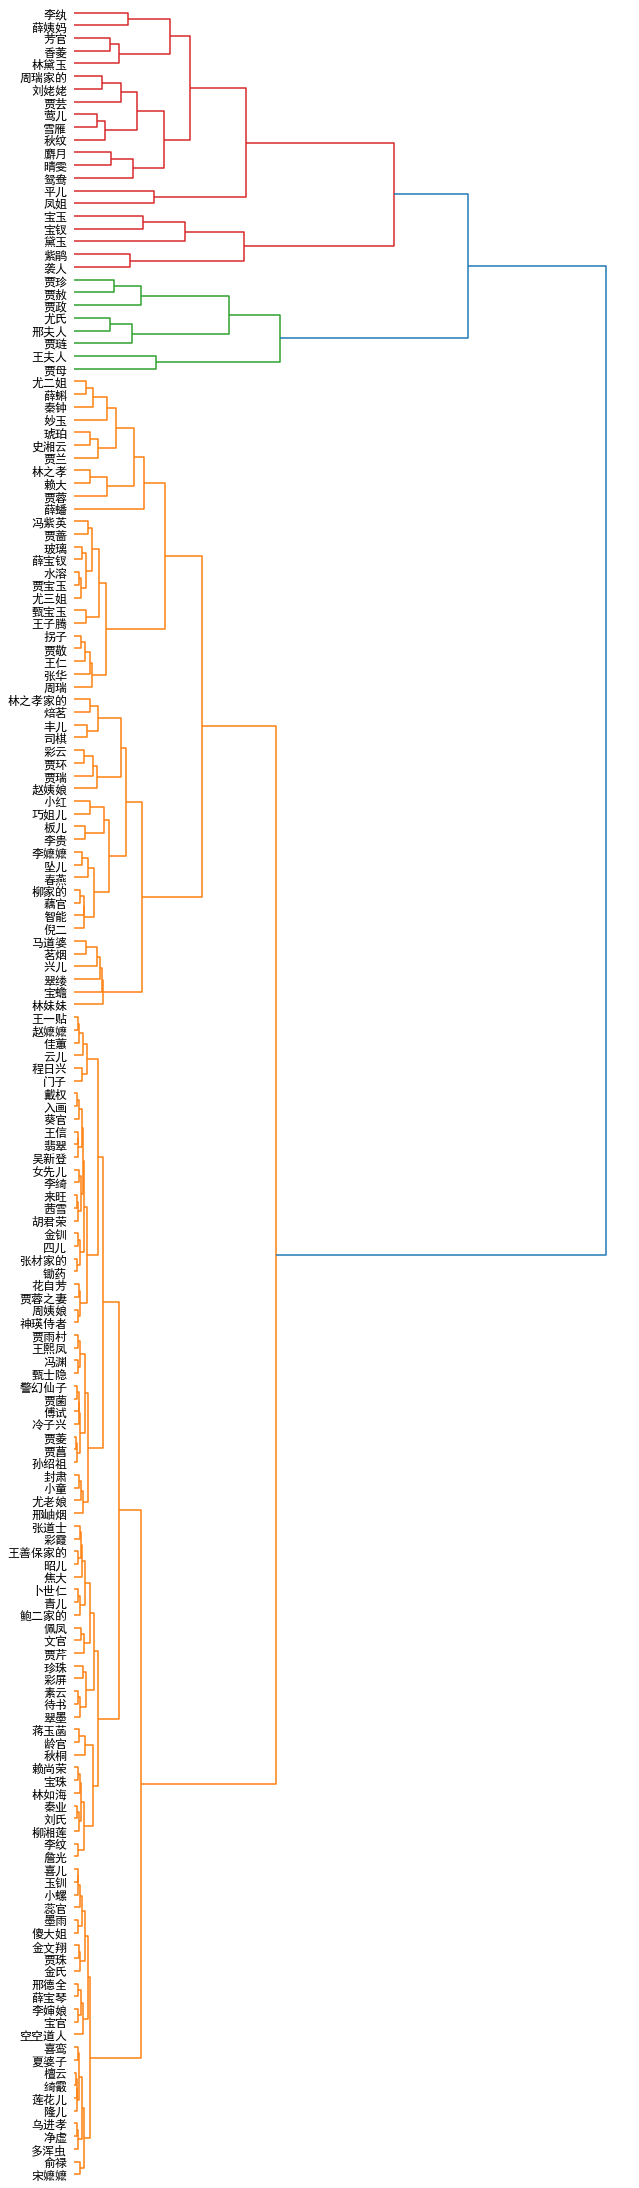

In [90]:
import scipy.cluster.hierarchy as sch
def hierarchy(np_names, word_vectors):
    Y = sch.linkage(word_vectors, method="ward")

    _, ax = plt.subplots(figsize=(10, 40))

    Z = sch.dendrogram(Y, orientation='right')
    idx = Z['leaves']

    ax.set_xticks([])
    ax.set_yticklabels(np_names[idx], fontproperties = 'SimHei' ,
                       fontsize=12)
    ax.set_frame_on(False)

    plt.show()
    
hierarchy(np_names, word_vectors)

### 数据降维

In [32]:
import numpy as np
from sklearn.decomposition import PCA
renwu = model.wv.most_similar('林黛玉', topn = 20)
print(renwu)
rawWordVec = []
word2ind = {}
for i, w in enumerate(model.wv.key_to_index):
    rawWordVec.append(model.wv[w])
    word2ind[w] = i
rawWordVec = np.array(rawWordVec)
X_reduced = PCA(n_components=2).fit_transform(rawWordVec)

[('推', 0.9808698892593384), ('撑不住', 0.954430341720581), ('那五儿', 0.953656017780304), ('伏', 0.9529597759246826), ('发呆', 0.9473252892494202), ('答言', 0.9433645606040955), ('响', 0.9410557150840759), ('嚷起来', 0.9371476173400879), ('可好', 0.9359544515609741), ('向黛玉', 0.9340417981147766), ('香菱', 0.9318670630455017), ('哇', 0.9310880899429321), ('瘦', 0.9307663440704346), ('一杯', 0.9305305480957031), ('伤心', 0.9304214119911194), ('声气', 0.9296647906303406), ('呆呆', 0.9290504455566406), ('流下泪来', 0.9282912015914917), ('呆', 0.9263050556182861), ('床前', 0.9247955679893494)]


### 人物关系投影

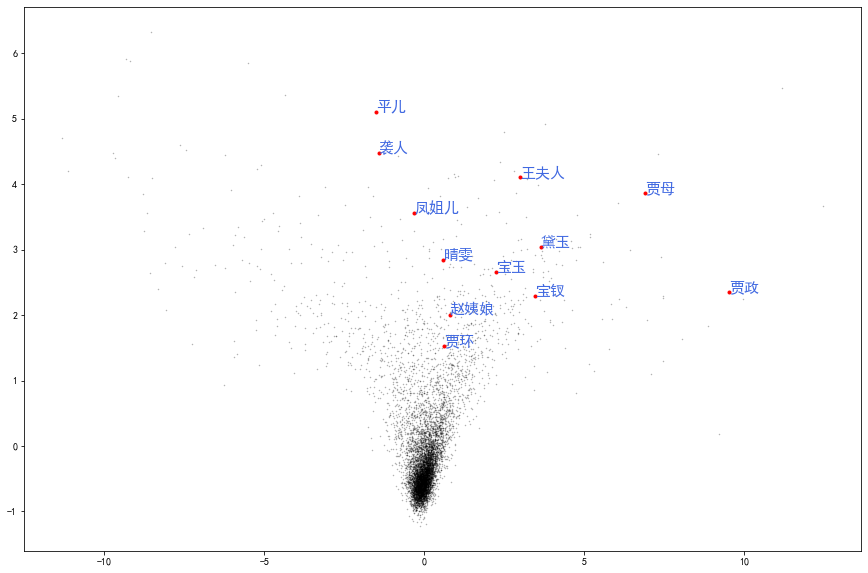

In [65]:
import matplotlib.pyplot as plt
import matplotlib
# 绘制所有单词向量的二维空间投影

fig = plt.figure(figsize = (15, 10))
ax = fig.gca()
ax.set_facecolor('white')
ax.plot(X_reduced[:, 0], X_reduced[:, 1], '.', markersize = 1, alpha = 0.3, color = 'black')


# 绘制几个特殊单词的向量
words = ['宝玉', '黛玉', '贾政', '晴雯', '袭人', '宝钗', '凤姐儿', '平儿', '贾母','王夫人','贾环','赵姨娘']
# 设置中文字体，否则无法在图形上显示中文
zhfont1 = matplotlib.font_manager.FontProperties(fname=r'C:\Users\mzjj\Desktop\基于Python的红楼梦文本分析\input\SimHei.ttf')
for w in words:
    if w in word2ind:
        ind = word2ind[w]
        xy = X_reduced[ind]
        plt.plot(xy[0], xy[1], '.', alpha =1, color = 'red')
        plt.text(xy[0], xy[1], w,  alpha = 1, color = 'royalblue',size=15)
plt.show()

### 人物关系网络图

In [66]:
from pyecharts import options as opts
from pyecharts.charts import Graph
nodes=[]
links=[]
cha_names=['宝玉', '贾母', '王熙凤', '黛玉', '宝钗', '王夫人', '探春', '袭人', '晴雯','刘姥姥','香菱','紫鹃','惜春']
sum=0
for w in cha_names:
    if model.wv.key_to_index.get(w):
        for i in model.wv.most_similar(positive=[w]):
            sum+=i[1]
        nodes.append({'name': w, 'symbolSize': 200/sum})
length=[]      
for i in cha_names:
        for j in cha_names:
            values=round((model.wv.similarity(i,j)+0),2)
            length.append(values)
            links.append(opts.GraphLink(source=i, target=j, value=values))

e = (
    Graph()
    .add("", nodes, links, 
         gravity=0.1,
         edge_label=opts.LabelOpts(is_show=True,position="middle",formatter="{c}"),
         repulsion=5000,
         layout="circular",
         linestyle_opts=opts.LineStyleOpts(opacity=0.7),
         edge_length=np.array(length)
         )
    .set_global_opts(title_opts=opts.TitleOpts(title="红楼梦人物关系图"))

)

e.render_notebook()


In [185]:
import networkx as nx
nodes=[]
links=[]
cha_names=['宝玉', '贾母', '王熙凤', '黛玉', '宝钗', '王夫人', '探春', '袭人', '晴雯']
for w in cha_names:
    if model.wv.key_to_index.get(w):
        nodes.append(w)
#生成无向图
G=nx.Graph()
#给图添加节点
for i in range(0,np.size(nodes)):
    G.add_node(i)
#添加带权的边
for i in range(0,np.size(nodes)):
    for j in range(0,np.size(nodes)):
        G.add_weighted_edges_from([(i,j,model.wv.similarity(i,j)+0)])

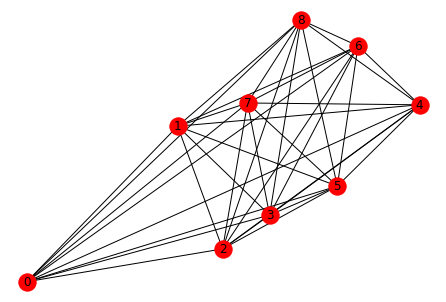

<Figure size 864x720 with 0 Axes>

In [186]:
nx.draw_spring(G, with_labels=True, node_color='red')
plt.figure(figsize=(12,10))
plt.rcParams['font.family'] = ['Fangsong'] 
plt.show()